In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Параметры модели

In [2]:
# periods of repetition we're going to search for
HISTORY_TIMES = np.array([4, 8, 16, 32, 48, 64, 96, 128])

# time (binary coded) as additional input 
TIME_AS_INPUT_SIZE = 6

# number of voices in polyphonic sampling scheme
VOICES = 5

# for gradient calculation stability (is it needed?)
epsilon = 1e-06

In [3]:
# Network Parameters
num_input = 12 + TIME_AS_INPUT_SIZE         # dimension of one input at moment
num_hidden_local = 100                      # dimension of LSTM for local dependencies 
num_hidden_read = 100                       # dimension of LSTM for reading from history
num_hidden_aggreg = 130                     # dimension of aggregation layer
num_hidden_voicegen = 100                   # dimension of voices generation layer
num_output = 12                             # output dimension for each voice

num_hidden_decoder = 100                    # dimension of decoder LSTM
num_decoder_output = 88                     # dimension of decoder output

## Модель

In [28]:
INDICES = Variable(torch.LongTensor(HISTORY_TIMES - 1))

class HistoryReader(nn.Module):
    def __init__(self):
        super(HistoryReader, self).__init__()
        
        self.read_lstm = nn.LSTM(num_input, num_hidden_read)        
        self.read_linear = nn.Linear(num_hidden_read, len(HISTORY_TIMES))
    
    def init_hidden(self, batch_size, history_init=None):
        self.hidden = (Variable(torch.zeros(1, batch_size, num_hidden_read)),
                       Variable(torch.zeros(1, batch_size, num_hidden_read)))
        
        self.history = history_init        
    
    def forward(self, x):        
        read_index, self.hidden = self.read_lstm(x, self.hidden)                
        read_index = F.softmax(self.read_linear(read_index), dim=2)
        self.read_index = read_index.data[0].numpy()
        
        self.history = torch.cat([x[0][:, None, :num_output], self.history[:, :-1]], dim=1)
        variants = torch.index_select(self.history, 1, INDICES)
        
        read = torch.bmm(read_index[0,:,None], variants).squeeze(1)       
        
        return read[None]

In [78]:
class PolyphonySampler(nn.Module):
    def __init__(self):
        super(PolyphonySampler, self).__init__()
        
        self.lstm = nn.LSTM(num_hidden_aggreg + 2*num_output, num_hidden_voicegen)
        self.linear = nn.Linear(num_hidden_voicegen, 2*num_output)
        
    def init_hidden(self, batch_size):        
        self.hidden = []
        for i in range(VOICES):
            self.hidden.append((Variable(torch.zeros(1, batch_size, num_hidden_voicegen)),
                                Variable(torch.zeros(1, batch_size, num_hidden_voicegen))))
    
    def forward(self, x, next_x=None):
        sampled_notes = torch.zeros(1, x.size()[1], num_output)        
        sample_p = Variable(torch.zeros(1, x.size()[1], num_output))
        neg_sample_p = Variable(torch.ones(1, x.size()[1], num_output))
                                
        banned_notes = torch.zeros(1, x.size()[1], num_output)       
        ban_p = Variable(torch.zeros(1, x.size()[1], num_output))
        neg_ban_p = Variable(torch.ones(1, x.size()[1], num_output))
        
        self.voice_distributions = []
        self.voice_decisions = []
        
        for i in range(VOICES):
            all_input = torch.cat([x, Variable(sampled_notes), Variable(banned_notes)], dim=2)
            coeff = (1 - torch.cat([sampled_notes, sampled_notes], dim=2)) * \
                    (1 - torch.cat([banned_notes, banned_notes], dim=2))
                             
            out, self.hidden[i] = self.lstm(all_input, self.hidden[i])
            out = self.linear(out)
            out = Variable(coeff) * torch.exp(out)                       
            out = out / out.sum(2)[:,:,None]
            
            self.voice_distributions.append(out.data[0].numpy())
            
            sample_p = sample_p + neg_sample_p * out[:,:,:num_output]
            neg_sample_p = neg_sample_p * (1 - out[:,:,:num_output])
                             
            ban_p = ban_p + neg_ban_p * out[:,:,num_output:]
            neg_ban_p = neg_ban_p * (1 - out[:,:,num_output:])
            
            sample = torch.LongTensor(x.size()[1], 2*num_output).zero_()
            sample.scatter_(1, torch.multinomial(out.squeeze(0).data, 1), 1)
            
            self.voice_decisions.append(sample.numpy())
            
            if self.training:
                sample = torch.cat([(sample[:,:num_output] + sample[:,num_output:]) * next_x,
                                    (sample[:,:num_output] + sample[:,num_output:]) * (1 - next_x)], dim=1)
            
            sampled_notes[0] += sample[:,:num_output].float()
            banned_notes[0]  += sample[:,num_output:].float()
        
        return sampled_notes, sample_p*(1 - ban_p)

In [79]:
import itertools
def time_generator():
    times = [np.array(t) for t in itertools.product([0, 1], repeat=TIME_AS_INPUT_SIZE)]
    t = 0
    
    while True:
        yield torch.FloatTensor(times[t])
        t = (t + 1) % len(times)

In [80]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.local_lstm = nn.LSTM(num_input, num_hidden_local)
        self.history_reader = HistoryReader()
        self.aggregation_lstm = nn.LSTM(num_output + num_hidden_local, num_hidden_aggreg)
        self.sampler = PolyphonySampler()
        
        self.init_hidden(1, None)
        
    def init_hidden(self, batch_size, history_init): 
        self.timer = time_generator()
        
        self.local_hidden = (Variable(torch.zeros(1, batch_size, num_hidden_local)),
                             Variable(torch.zeros(1, batch_size, num_hidden_local)))
        
        self.history_reader.init_hidden(batch_size, history_init)
        
        self.aggreg_hidden = (Variable(torch.zeros(1, batch_size, num_hidden_aggreg)),
                             Variable(torch.zeros(1, batch_size, num_hidden_aggreg)))
        
        self.sampler.init_hidden(batch_size)
    
    def forward(self, x, next_x=None):            
        inp = torch.cat([x, Variable(self.timer.__next__())[None, None].repeat(1, x.size()[1], 1)], dim=2)
        
        local_out, self.local_hidden = self.local_lstm(inp, self.local_hidden)            
        read = self.history_reader(inp)        
        out, self.aggreg_hidden = self.aggregation_lstm(torch.cat([local_out, read], dim=2), self.aggreg_hidden)
               
        return self.sampler(out, next_x)

In [81]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.lstm = nn.LSTM(num_output + num_decoder_output, num_hidden_decoder)  
        self.linear = nn.Linear(num_hidden_decoder, num_decoder_output)      
        self.init_hidden(1)
        
    def init_hidden(self, batch_size):        
        self.decoder_hidden = (Variable(torch.zeros(1, batch_size, num_hidden_decoder)),
                             Variable(torch.zeros(1, batch_size, num_hidden_decoder)))
    
    def forward(self, x, prev_x_decoded):            
        inp = torch.cat([x, prev_x_decoded], dim=2)
        
        out, self.decoder_hidden = self.lstm(inp, self.decoder_hidden) 
        out = F.sigmoid(self.linear(out))
        
        return out
    
    def sample(self, out):
        p = out.data.numpy()
        
        return np.random.uniform(size=num_decoder_output) < p #wrong

In [92]:
def learn(model, decoder, batch_x, batch_history_init, batch_decoded, optimizer, decoder_optimizer):
        
    model.init_hidden(batch_x.shape[1], Variable(torch.FloatTensor(batch_history_init)))
    decoder.init_hidden(batch_x.shape[1])
    model.train()
    decoder.train()

    optimizer.zero_grad()
    decoder_optimizer.zero_grad()
        
    basic_p = Variable(torch.FloatTensor(batch_x.shape[0] - 1, batch_x.shape[1], num_output)).zero_() 
    decoder_p = Variable(torch.FloatTensor(batch_x.shape[0] - 1, batch_x.shape[1], num_decoder_output)).zero_()  
    read_index, voice_distributions, voice_decisions = [], [], []
    
    for t in range(len(batch_x)-1):
        inp = Variable(torch.FloatTensor(batch_x[t]))[None]        
        _, basic_p[t] = model(inp, torch.LongTensor(batch_x[t+1]))
        
        decoder_inp = Variable(torch.FloatTensor(batch_x[t + 1]))[None], \
                      Variable(torch.FloatTensor(batch_decoded[t]))[None]
                       
        decoder_p[t] = decoder(*decoder_inp)
        
        read_index.append(model.history_reader.read_index)
        voice_distributions.append(model.sampler.voice_distributions)
        voice_decisions.append(model.sampler.voice_decisions)
        
    y = Variable(torch.FloatTensor(batch_x[1:]))
    loss = -(y * torch.log(basic_p) + (1 - y)*torch.log(1 - basic_p))
    loss_picture = loss.data.numpy()
    
    y = Variable(torch.FloatTensor(batch_decoded[1:]))
    mask = Variable(torch.FloatTensor(np.tile(batch_x[1:], (1, 1, 1 + num_decoder_output // num_output))[:,:,:num_decoder_output]))
    decoder_loss = -(y * torch.log(decoder_p) + (1 - y)*torch.log(1 - decoder_p))*mask
    decoder_loss_picture = decoder_loss.data.numpy()
    
    loss.mean().backward()
    (decoder_loss.sum() / mask.sum()).backward()
    
    optimizer.step()
    decoder_optimizer.step()
   
    return loss_picture, decoder_loss_picture, np.array(read_index), np.array(voice_distributions), np.array(voice_decisions)
        
def sample(model, decoder, start, decoder_start, time_limit):
    model.init_hidden(1, Variable(torch.zeros(1, int(HISTORY_TIMES.max()), num_output)))
    decoder.init_hidden(1)
    model.eval()
    decoder.eval()
    
    sample = []
    decoded_sample = []
    
    for t in range(len(start)):
        inp = Variable(torch.FloatTensor(start[t])[None, None])
        next_notes, _ = model(inp)
        
        decoder_inp = Variable(torch.FloatTensor(decoder_start[t])[None, None])
        next_decoded = decoder(decoder_inp, Variable(next_notes))
        
        sample.append(start[t])
        decoded_sample.append(decoder_start[t])
    
    sample.append(next_notes[0][0].numpy())
    mask = np.tile(sample[-1], (1 + num_decoder_output // num_output))[:num_decoder_output]
    decoded_sample.append(mask * (np.random.uniform(size=88) < next_decoded.data[0][0].numpy()))
        
    while len(sample) < time_limit:
        next_notes, _ = model(Variable(next_notes))
        
        decoder_inp = Variable(torch.FloatTensor(decoded_sample[-1].astype(np.float32))[None, None])
        next_decoded = decoder(Variable(next_notes), decoder_inp)
        
        sample.append(next_notes[0][0].numpy())
        
        mask = np.tile(sample[-1], (1 + num_decoder_output // num_output))[:num_decoder_output]
        decoded_sample.append(mask * (np.random.uniform(size=88) < next_decoded.data[0][0].numpy()))
        
    return np.array(sample), np.array(decoded_sample)

## Данные

In [93]:
songs = np.load("CP_dataset.npy")

In [94]:
batch_size = 80
fragment_lentgh = 256
fragment_step = 32

In [95]:
def compress(song):    
    compressed = song[:, :12]
    for i in range(1,7):
        compressed = np.logical_or(compressed, song[:, 12*i:12*i+12])            
    return compressed

In [96]:
song_fragments = []
csong_fragments = []
history_inits = []

for song in songs:
    csong = compress(song)
    
    history = np.zeros((HISTORY_TIMES.max(), 12))
    
    for i in range(0, csong.shape[0] - fragment_lentgh, fragment_step):
        song_fragments.append(song[i:i+fragment_lentgh])
        csong_fragments.append(csong[i:i+fragment_lentgh])
        
        history_inits.append(history.copy())        
        history = np.vstack([csong[i:i+fragment_step][::-1], history[fragment_step:]])

song_fragments = np.array(song_fragments)
csong_fragments = np.array(csong_fragments)
history_inits = np.array(history_inits)

In [97]:
def batchGenerator():
    while True:
        indexes = np.random.choice(np.arange(len(csong_fragments)), batch_size)
        batch_x, batch_history_init, batch_decoded = csong_fragments[indexes], history_inits[indexes], song_fragments[indexes]
                
        to_roll = np.random.randint(-6, 6)
        if to_roll > 0:
            batch_decoded[:, :, -to_roll:] = 0
        else:
            batch_decoded[:, :, :-to_roll] = 0

        batch_x = np.roll(batch_x, to_roll, axis=2)
        batch_history_init = np.roll(batch_history_init, to_roll, axis=2)
        batch_decoded = np.roll(batch_decoded, to_roll, axis=2)
        
        yield np.moveaxis(batch_x, 1, 0).astype(np.float32), \
              batch_history_init.astype(np.float32), \
              np.moveaxis(batch_decoded, 1, 0).astype(np.float32)

### Графика

In [98]:
def drawNotes(song, name="", scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(name)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 4))
    plt.show()

# Обучение

In [99]:
model = Model()
decoder = Decoder()

In [100]:
#model.load_state_dict(torch.load("my first pytorch model.pt"))

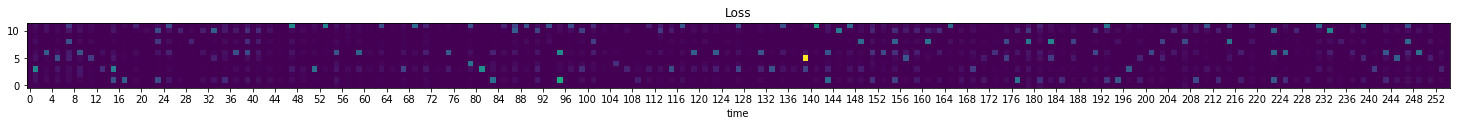

0.172712


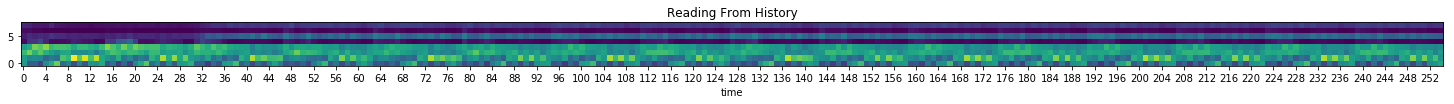

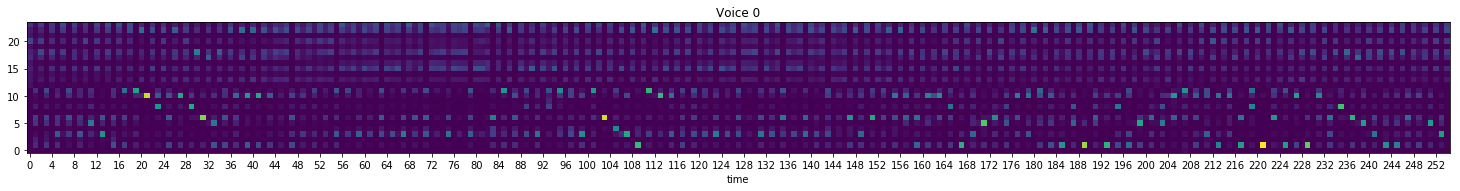

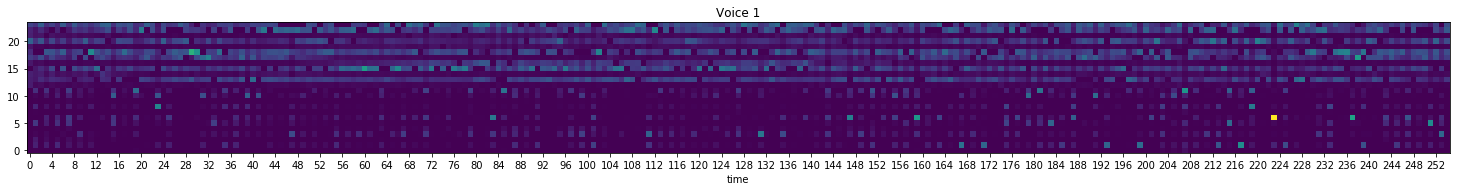

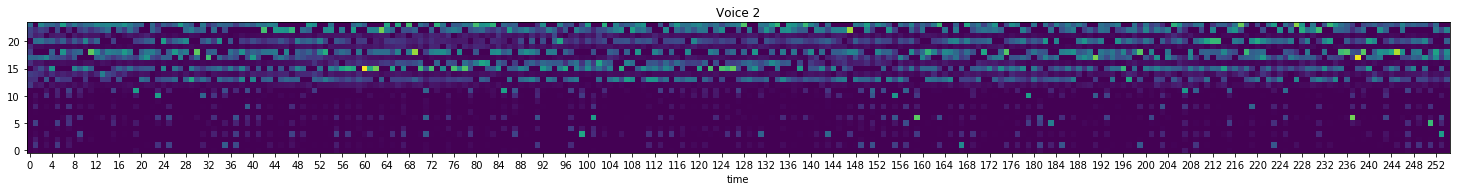

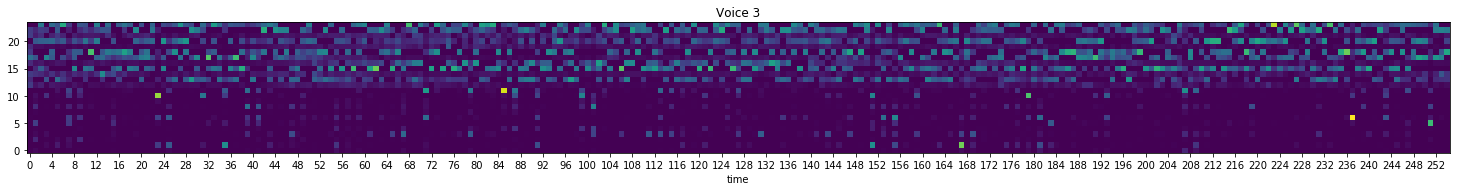

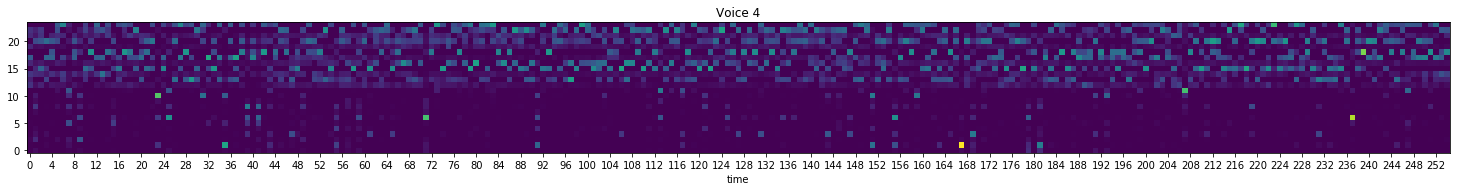

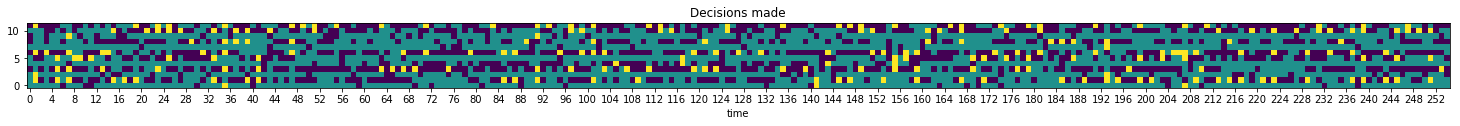

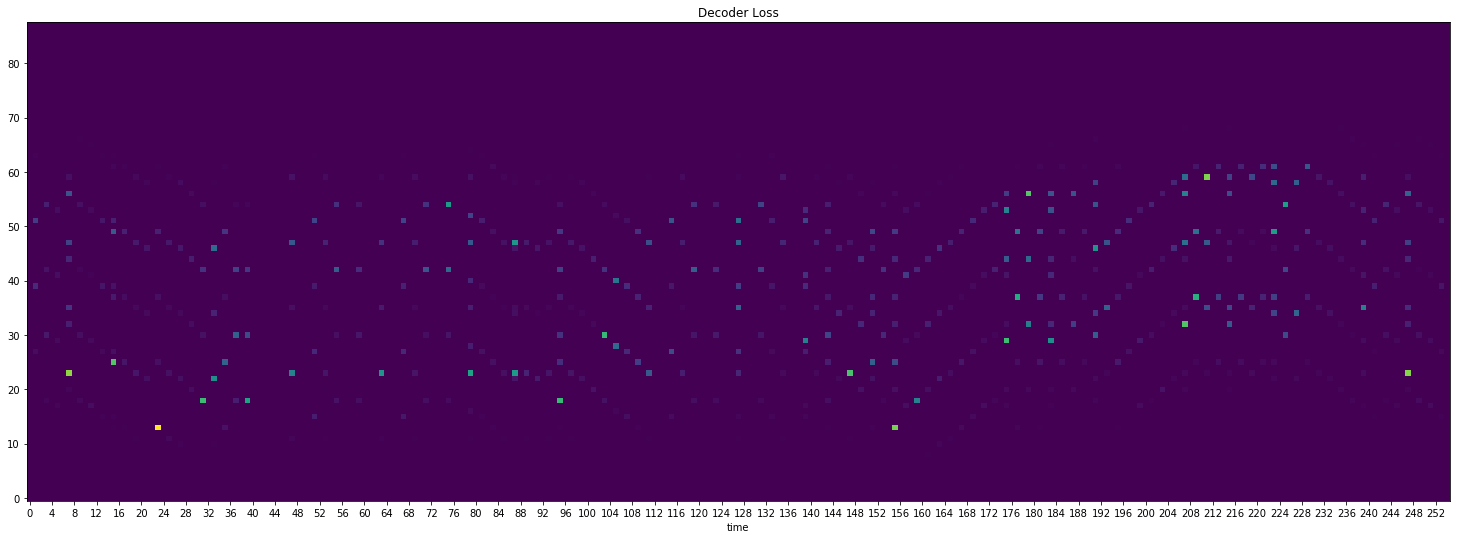

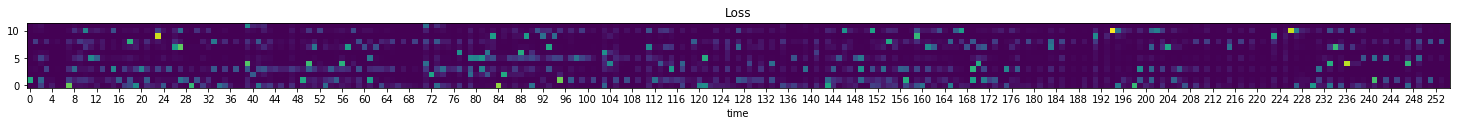

0.178626


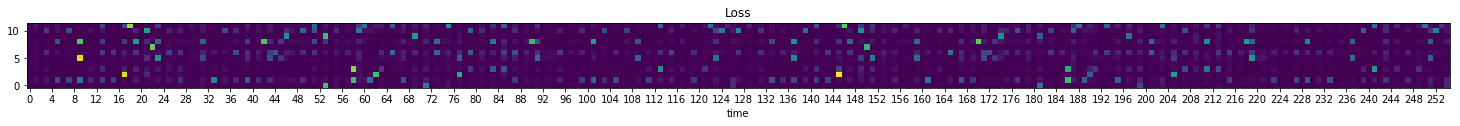

0.172565


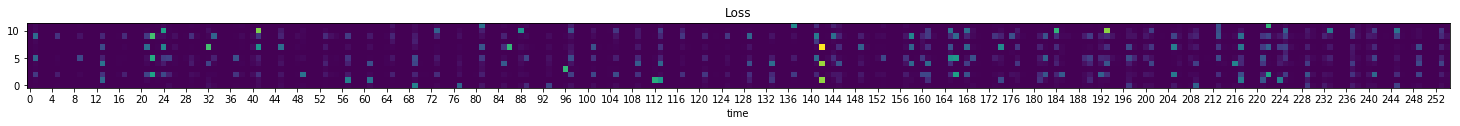

0.17419


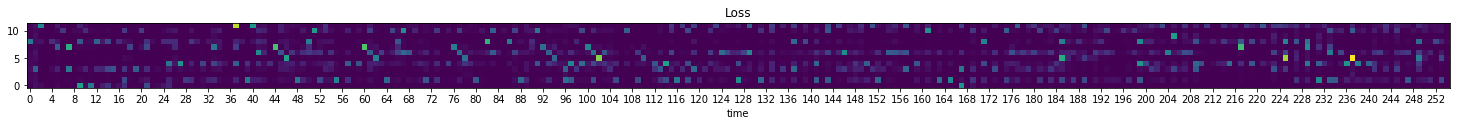

0.176304


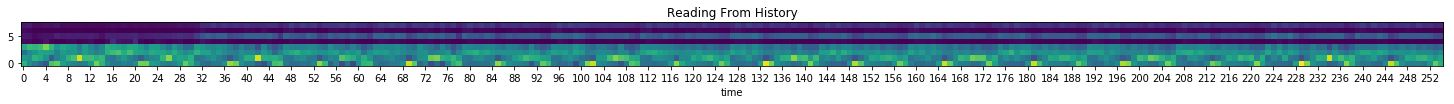

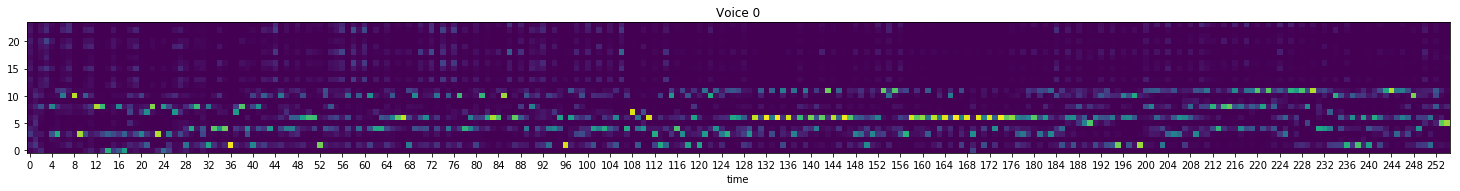

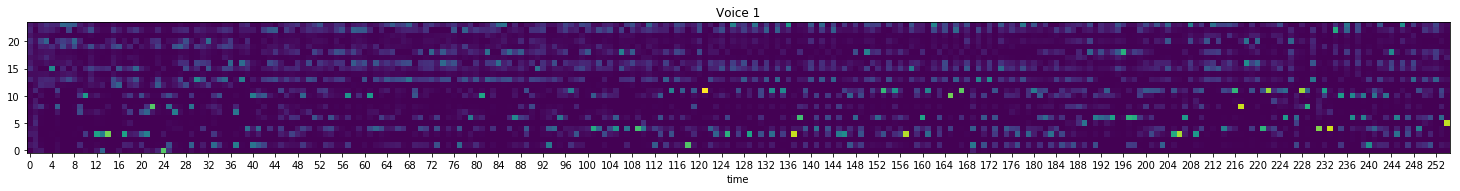

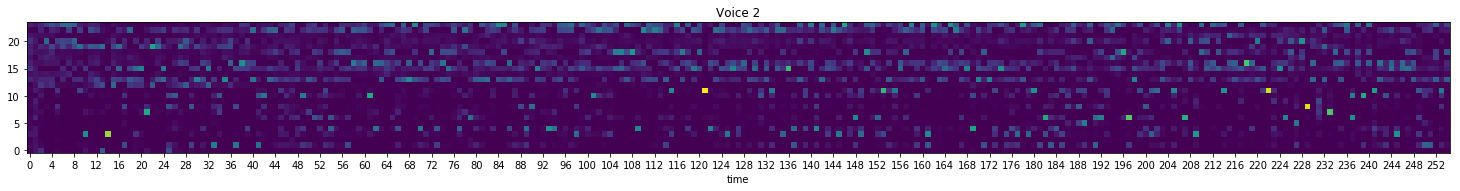

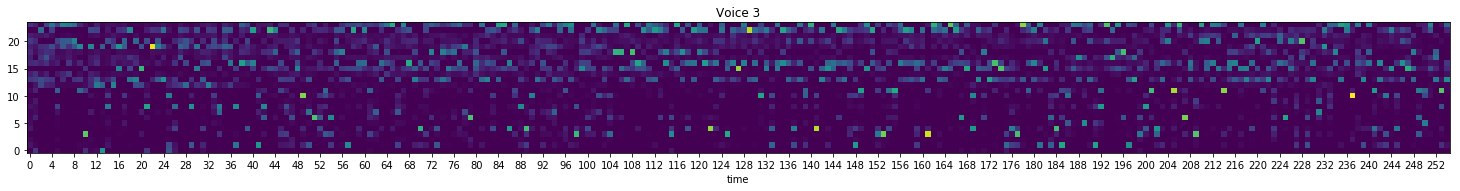

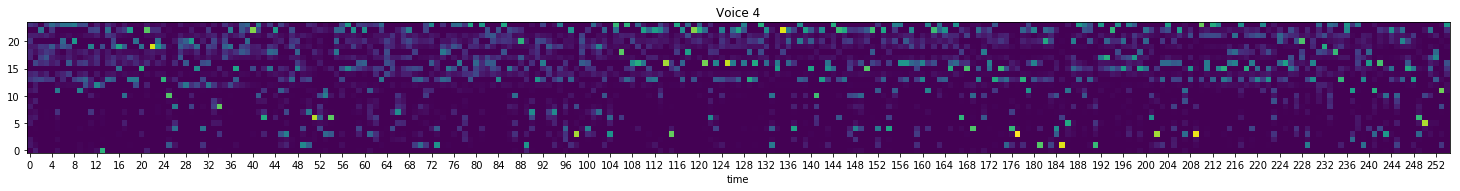

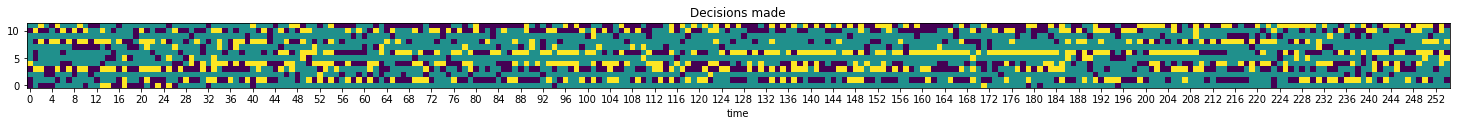

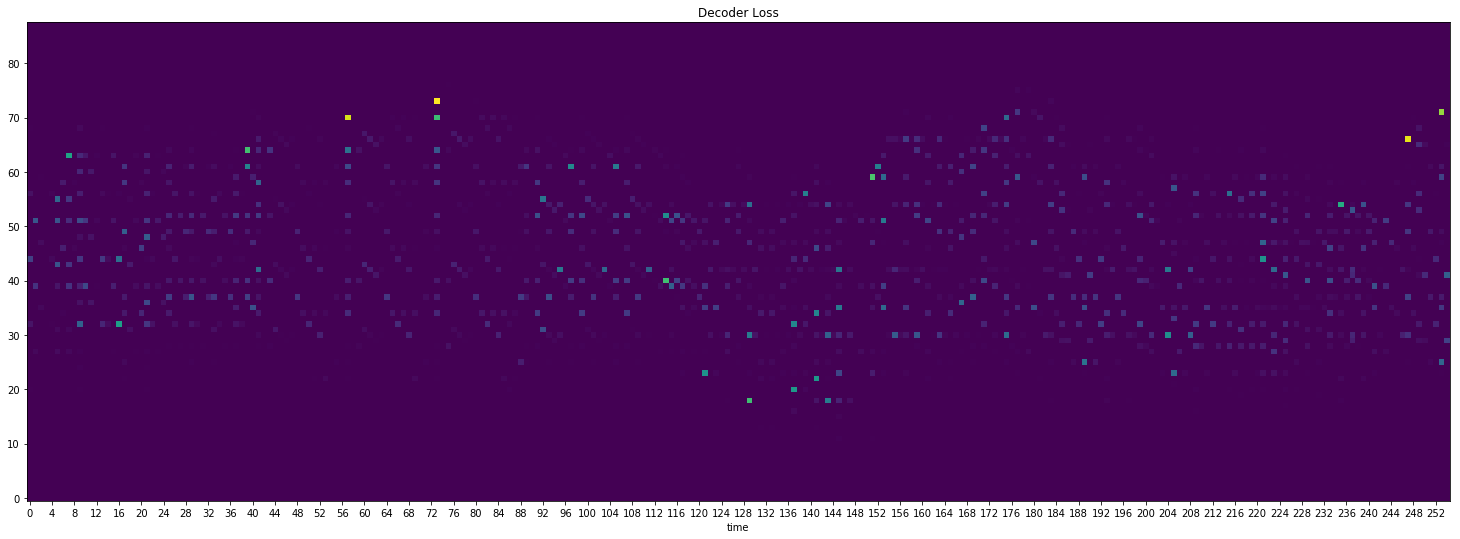

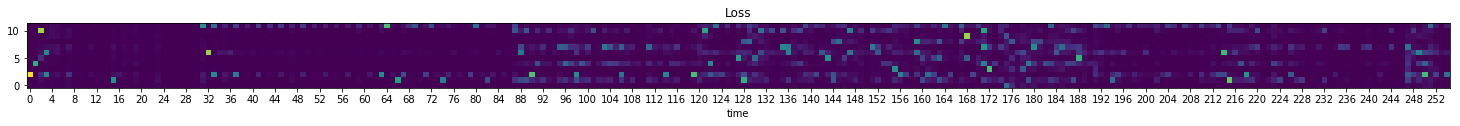

0.187987


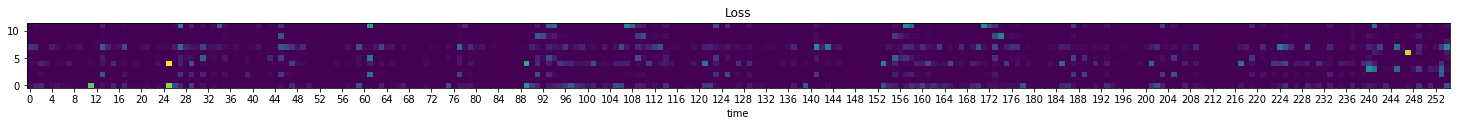

0.164681


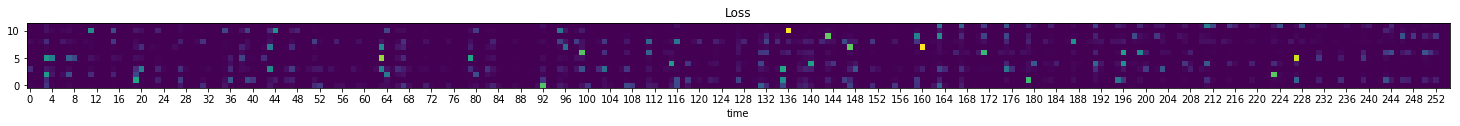

0.174708


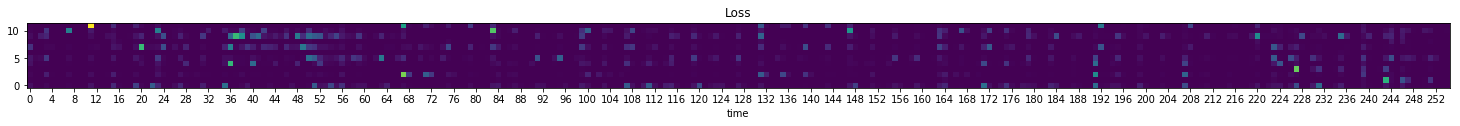

0.175749


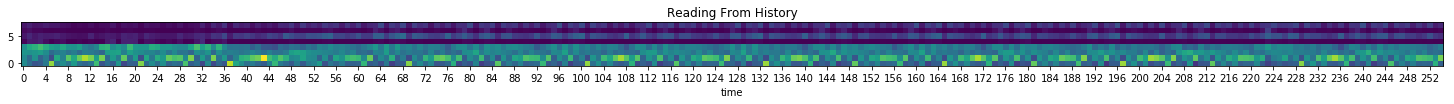

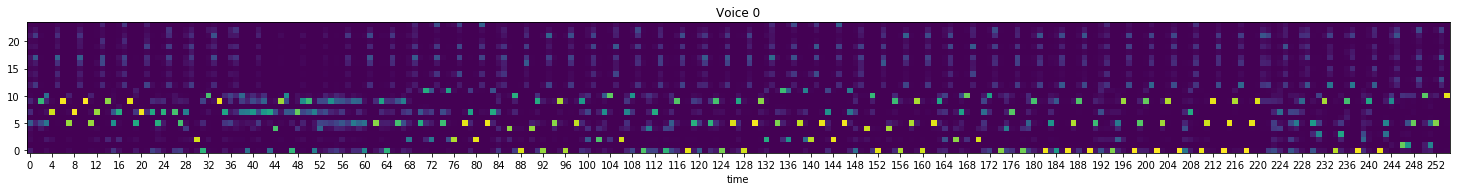

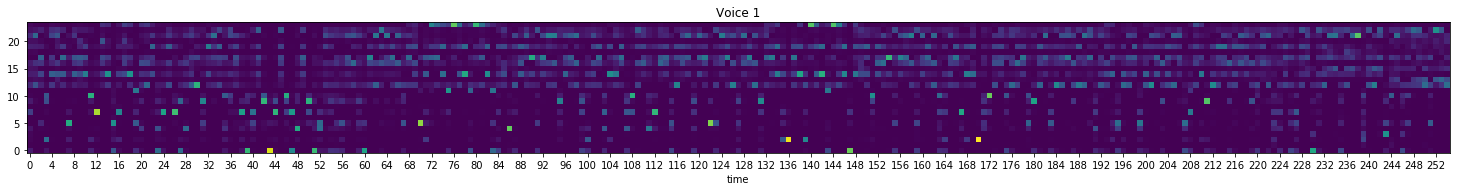

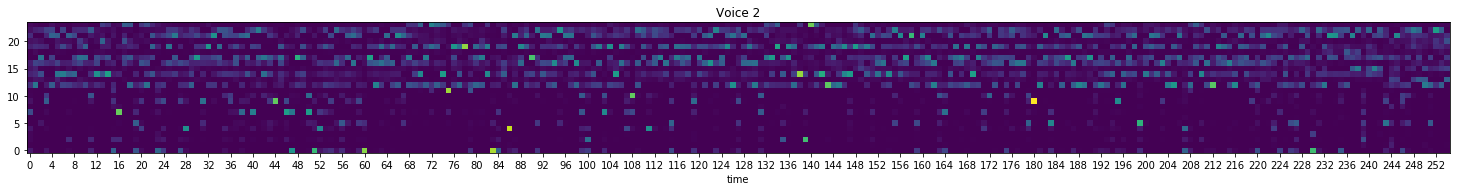

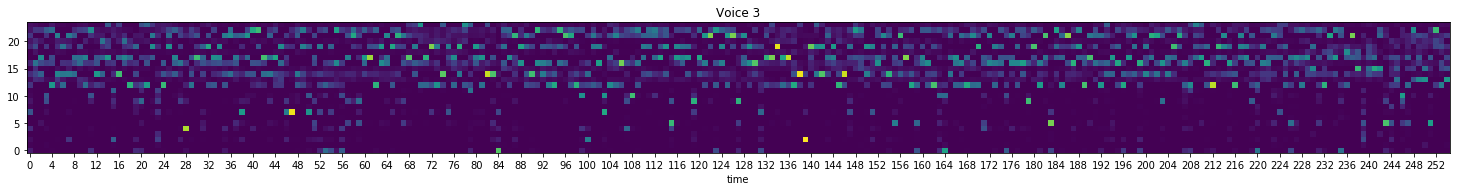

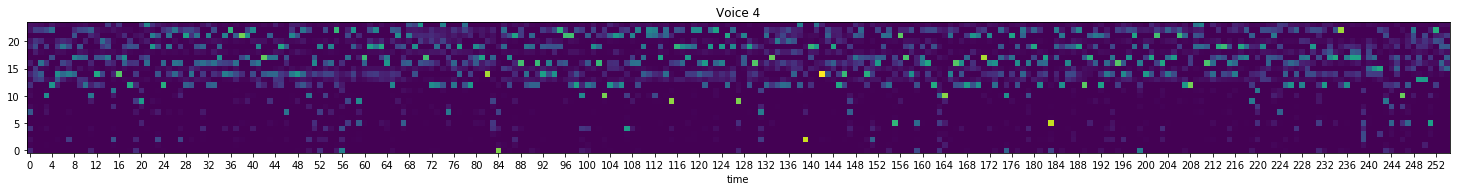

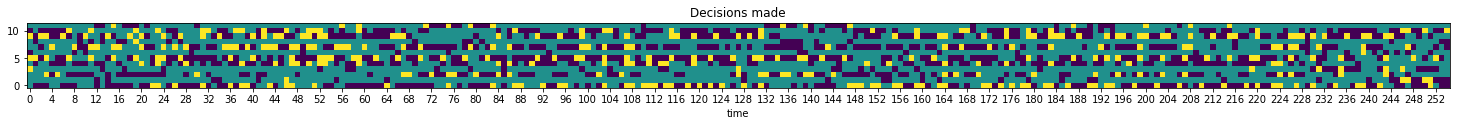

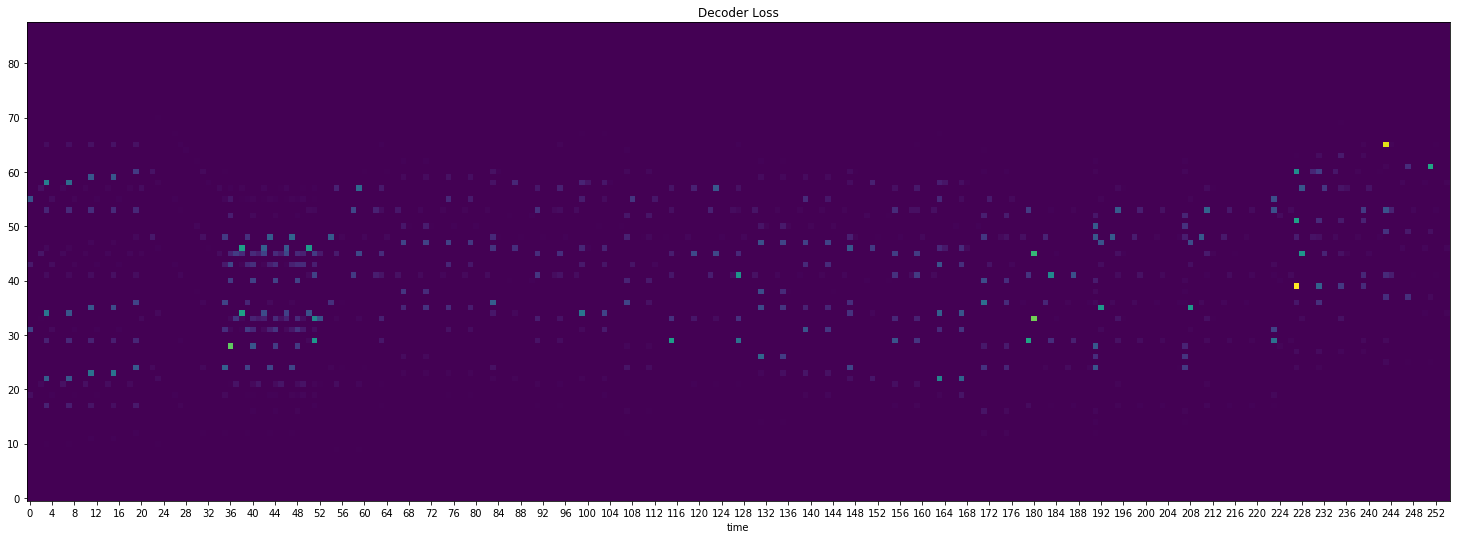

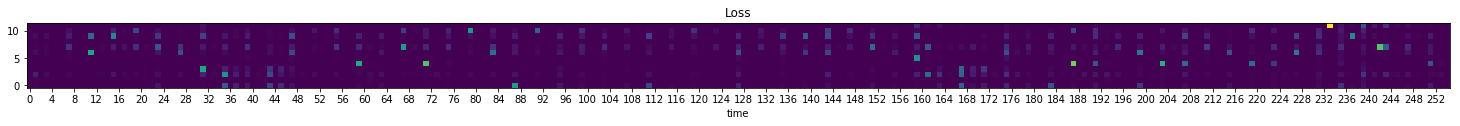

0.176648


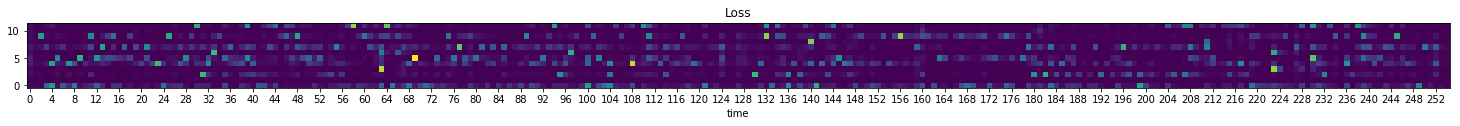

0.171393


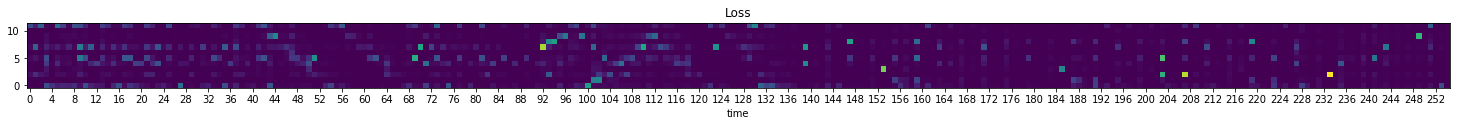

0.170686


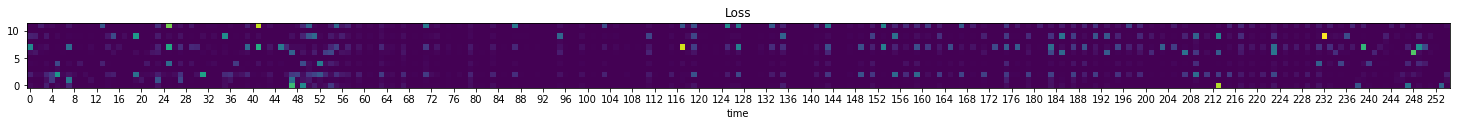

0.175664


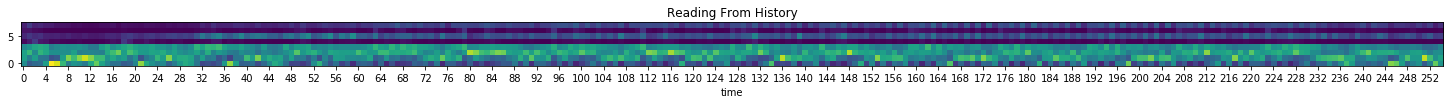

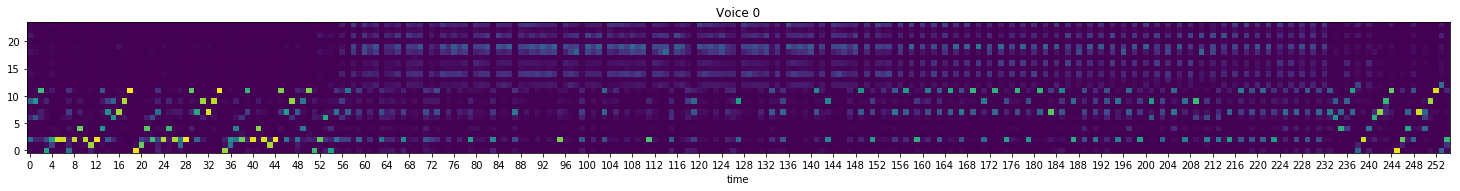

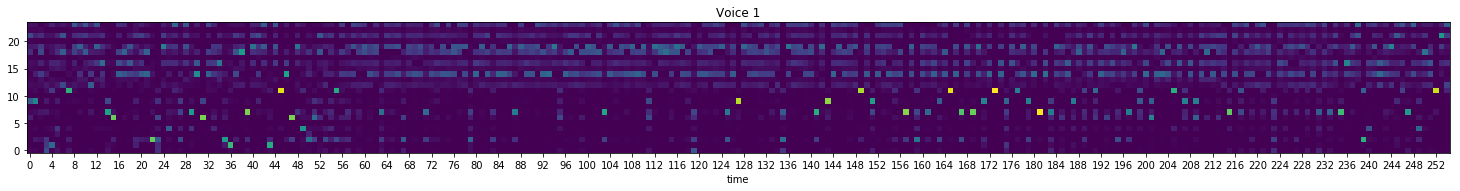

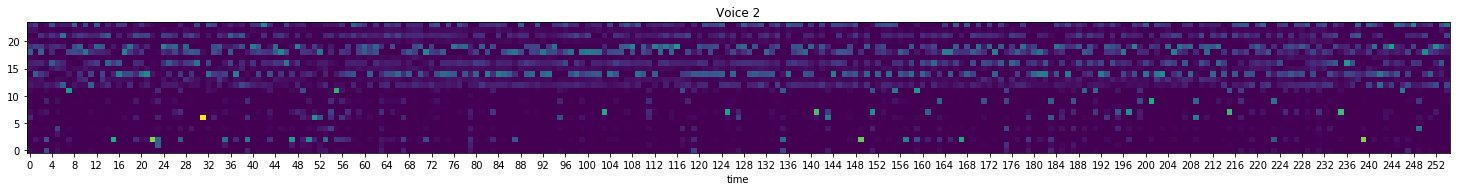

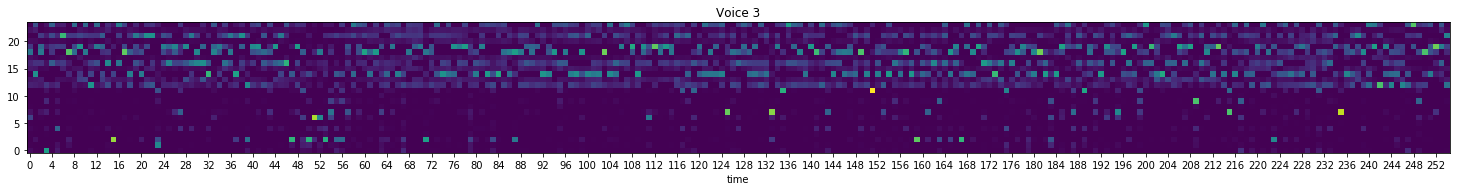

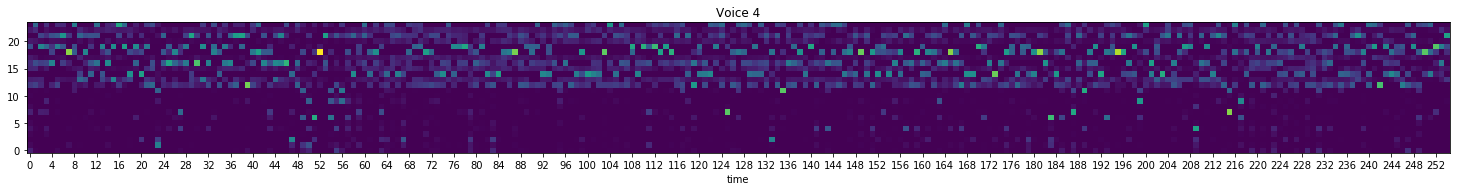

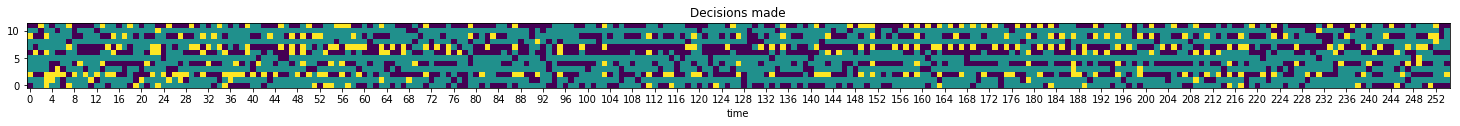

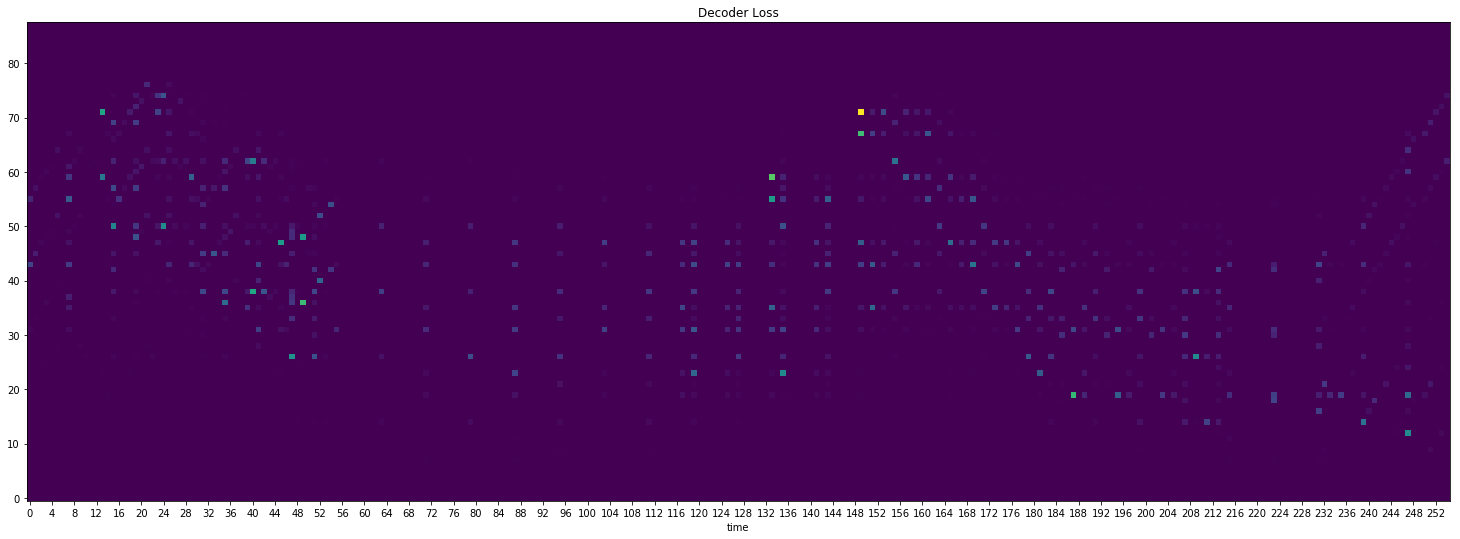

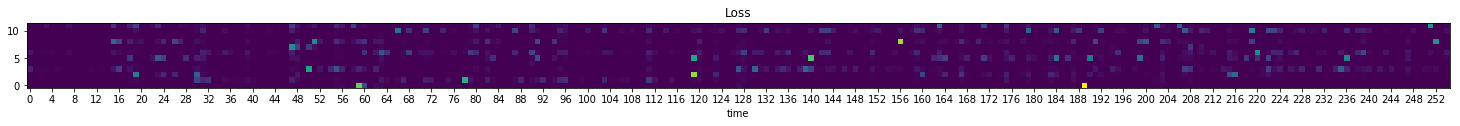

0.157858


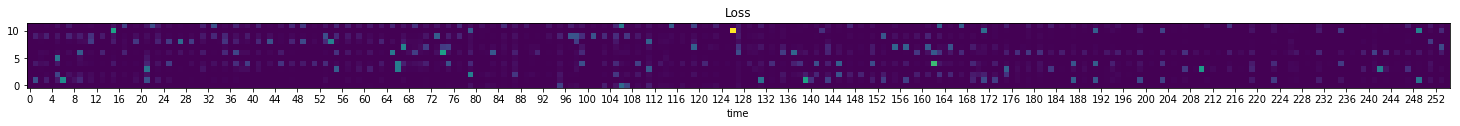

0.163131


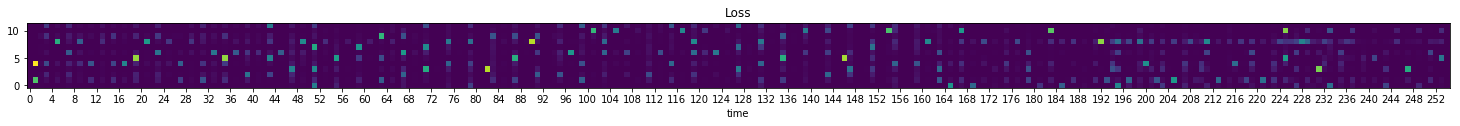

0.169818


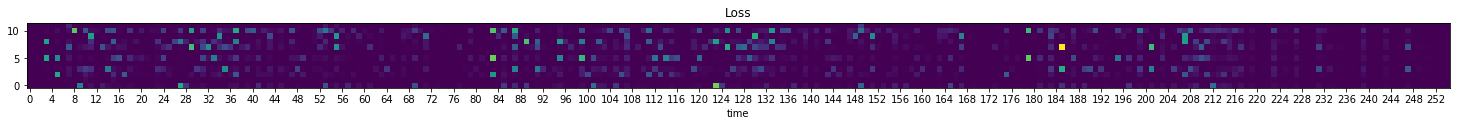

0.172019


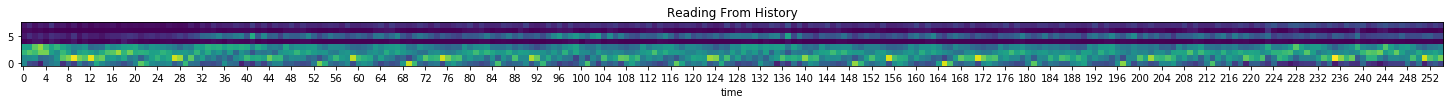

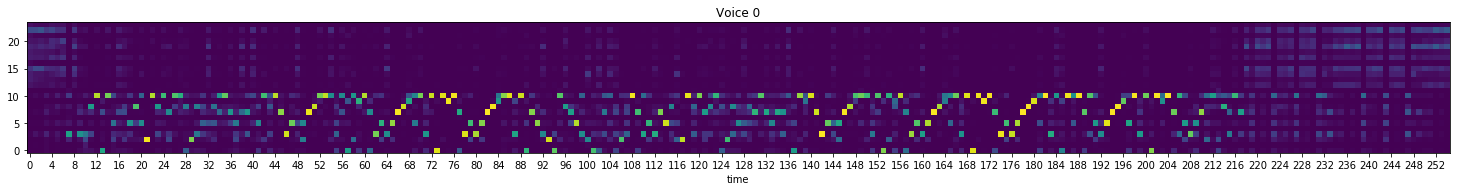

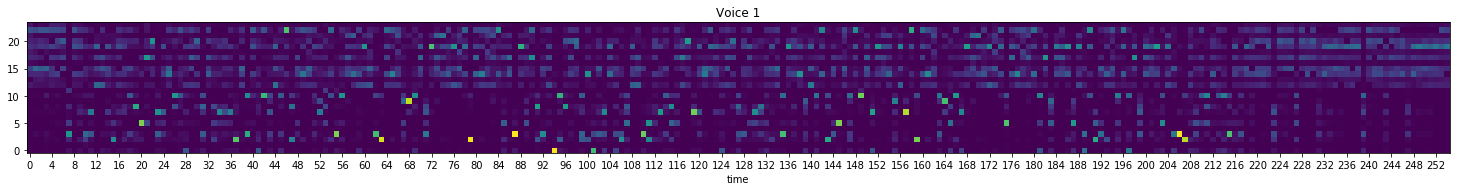

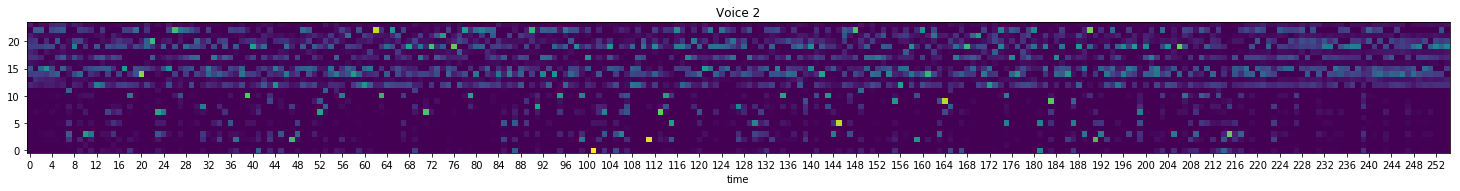

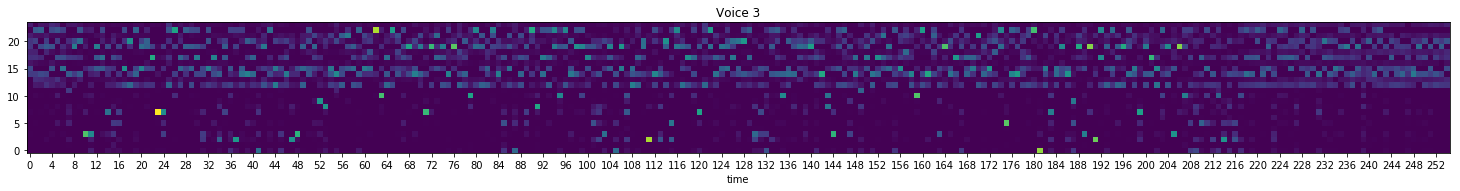

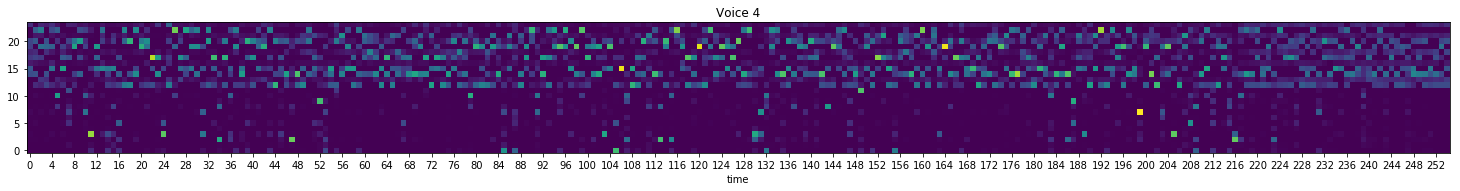

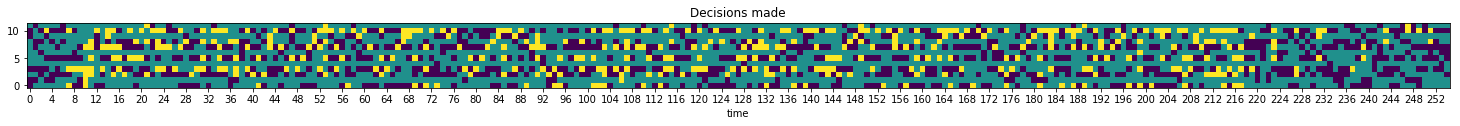

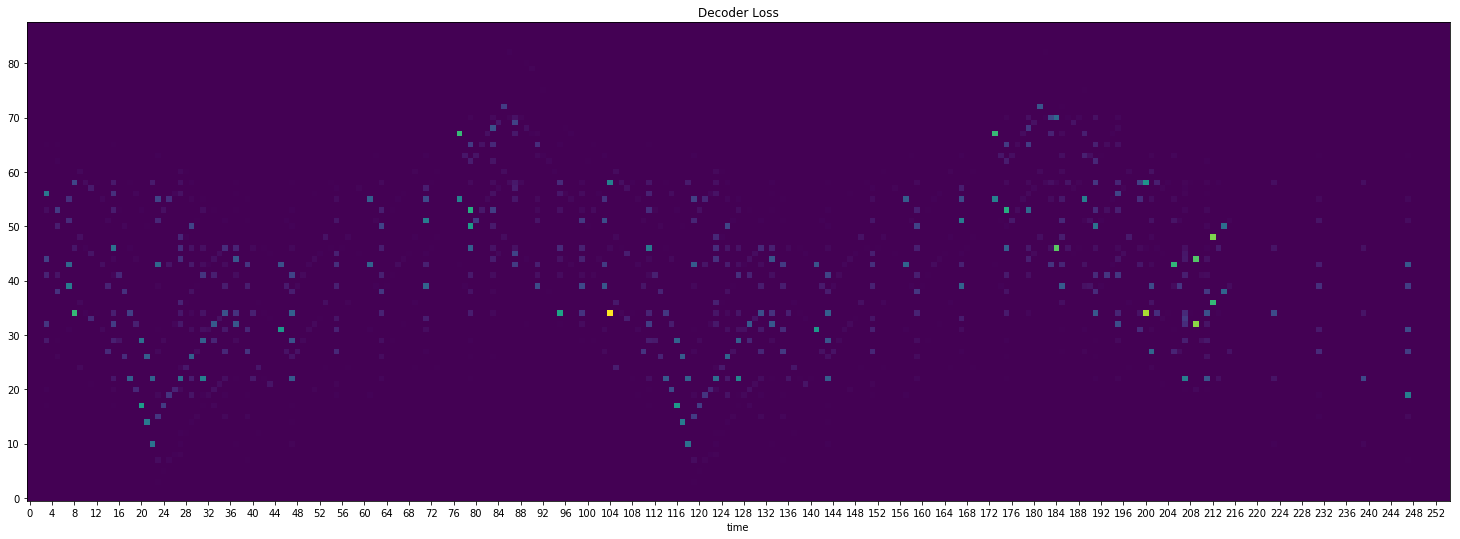

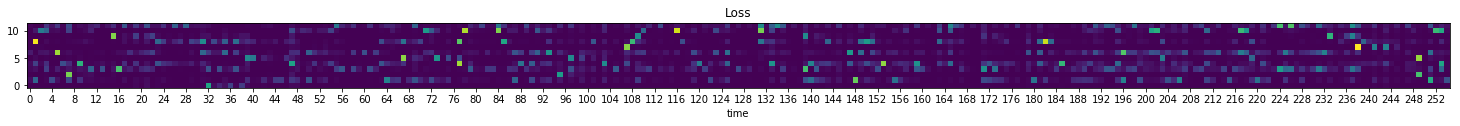

0.169815


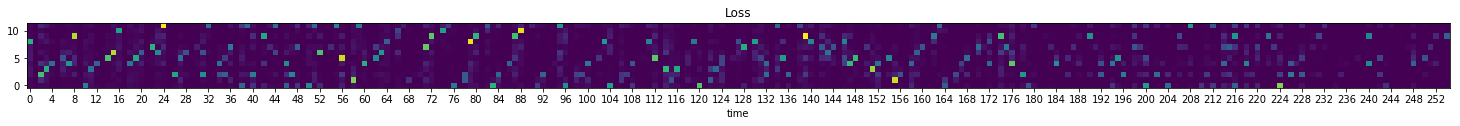

0.171942


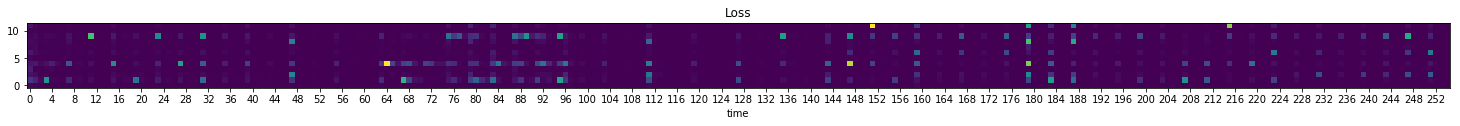

0.164818


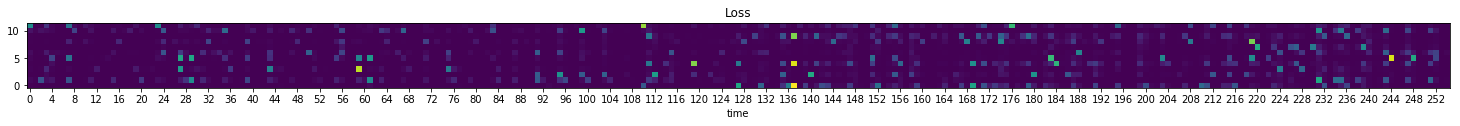

0.160854


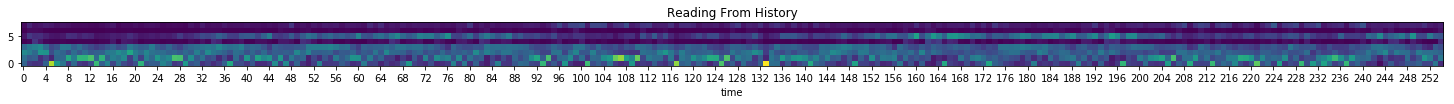

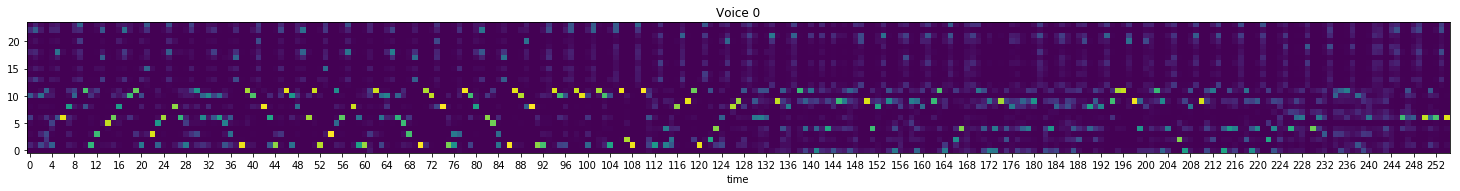

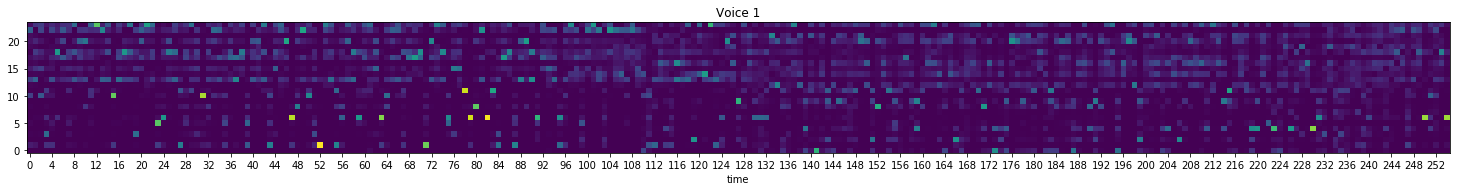

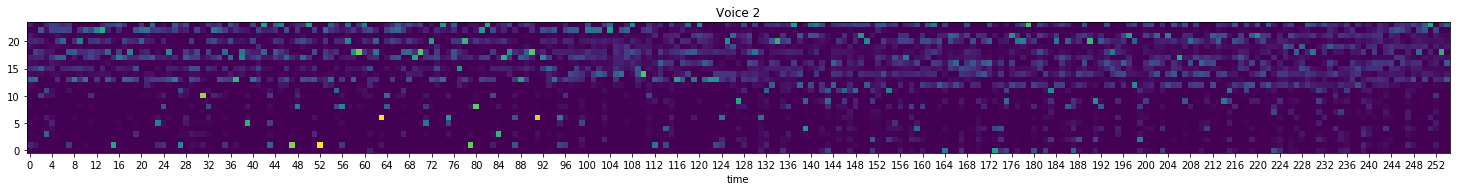

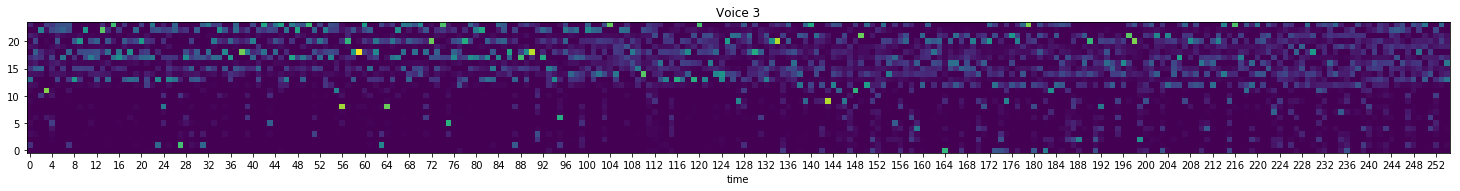

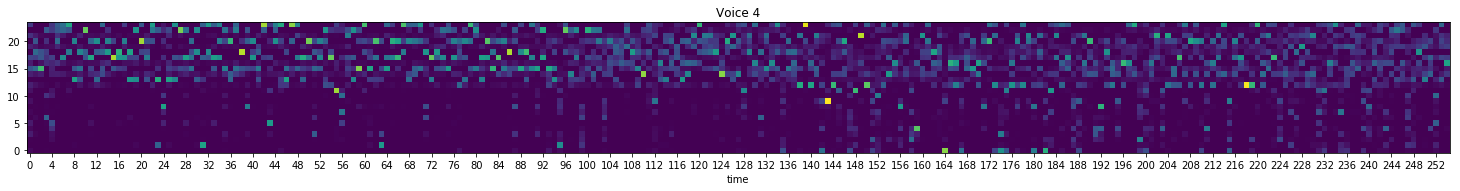

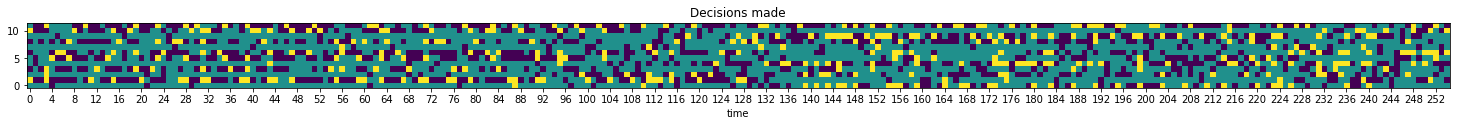

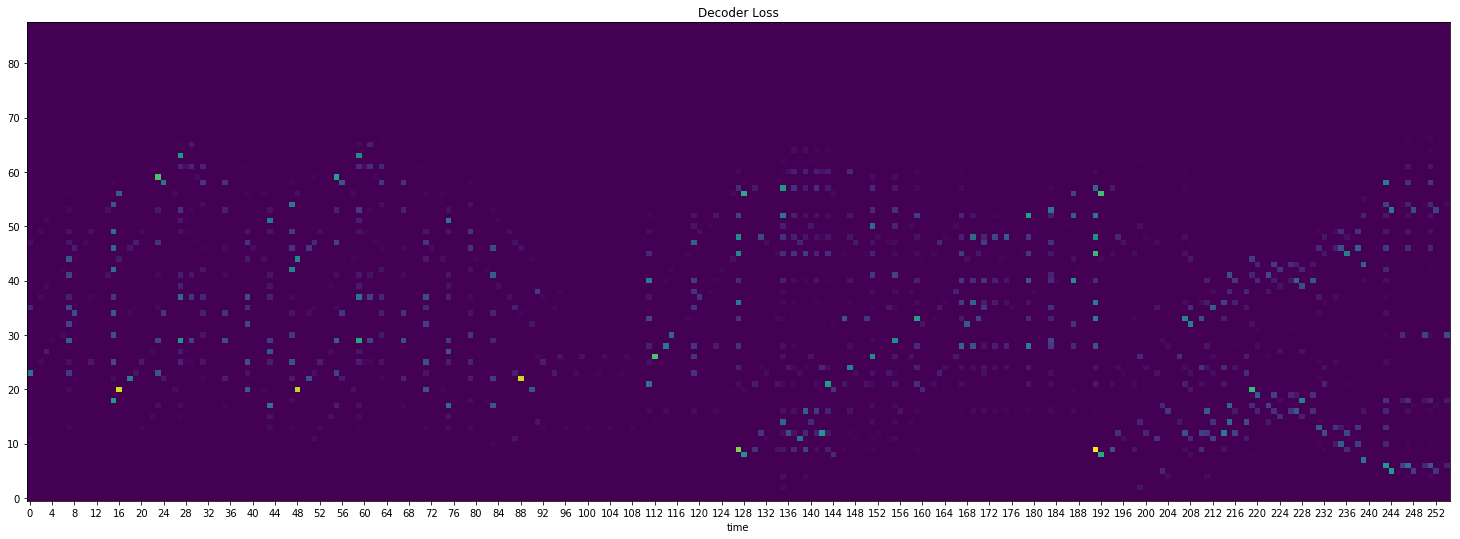

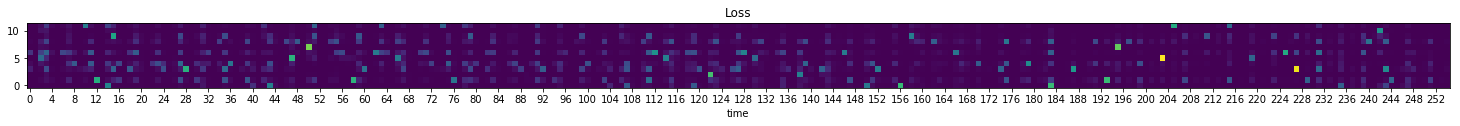

0.169227


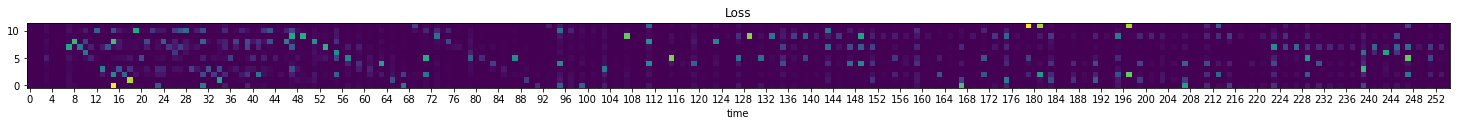

0.161006


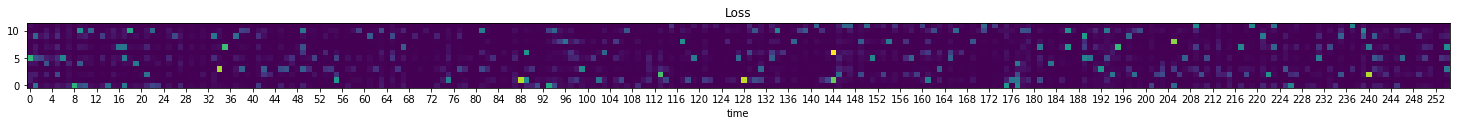

0.154483


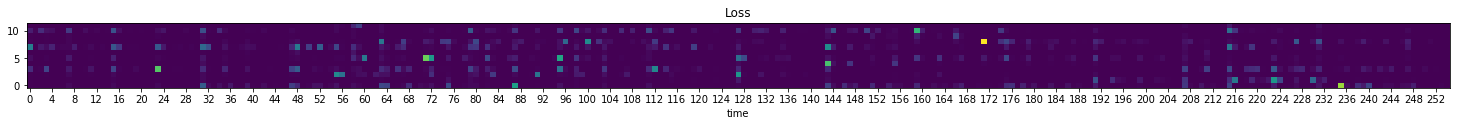

0.162487


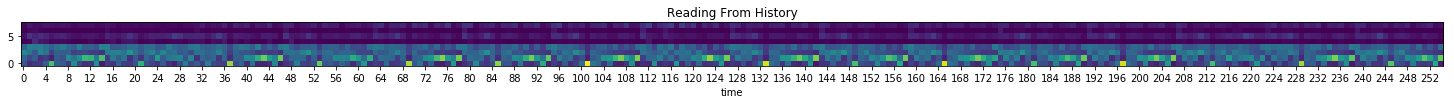

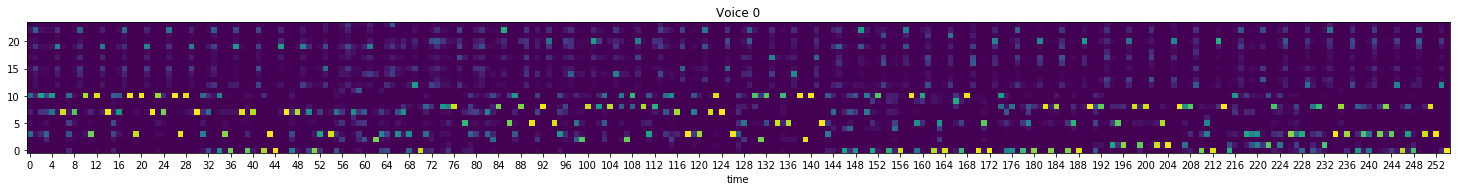

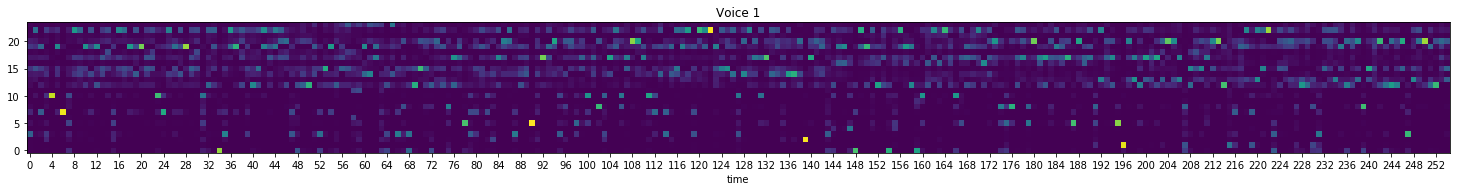

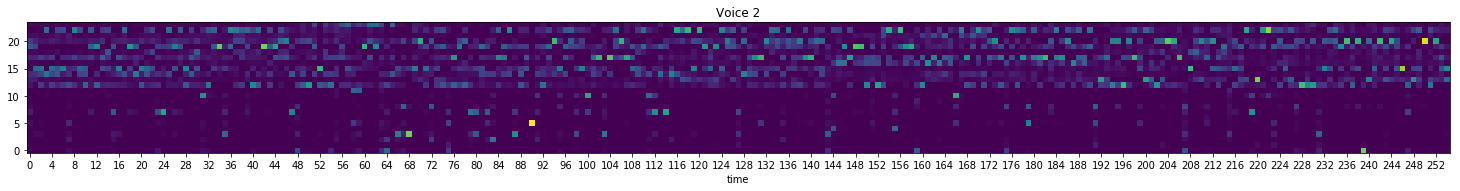

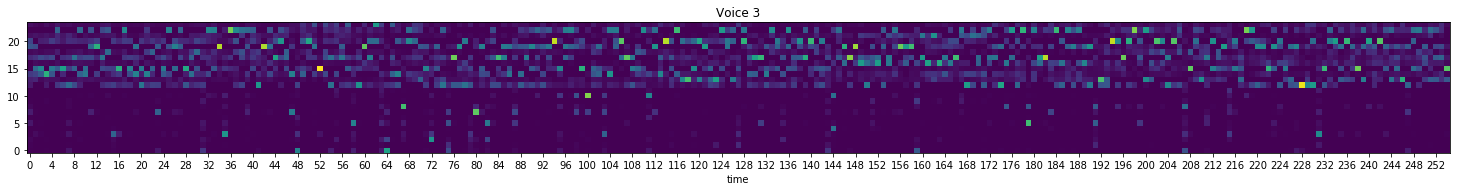

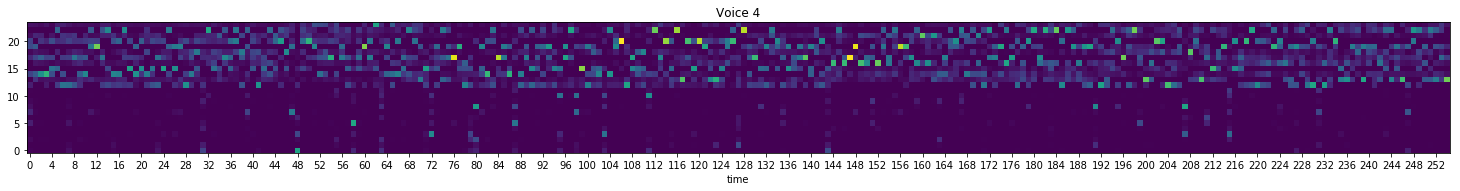

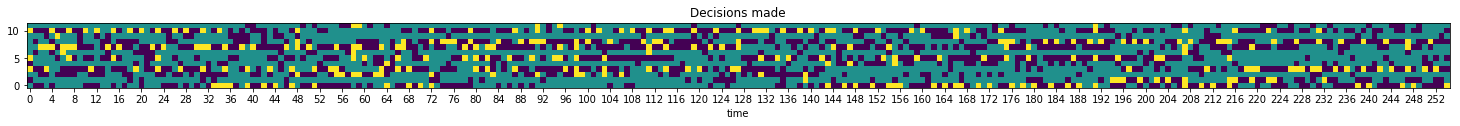

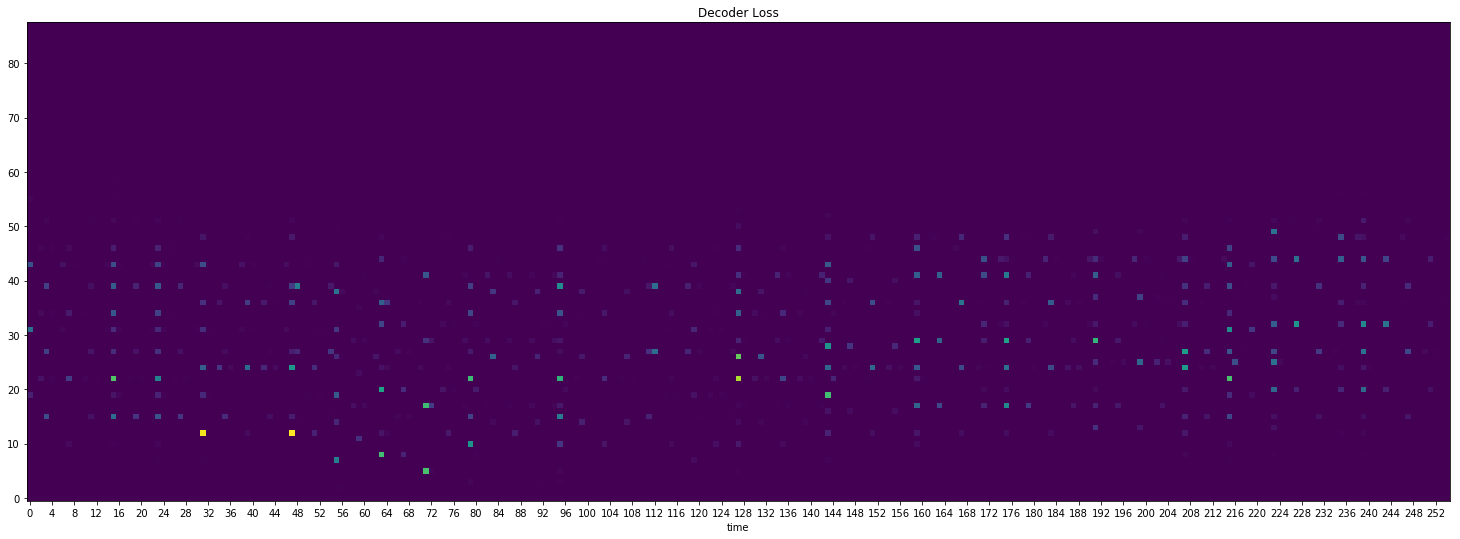

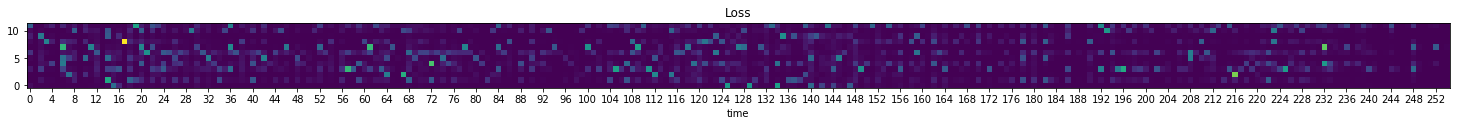

0.162319


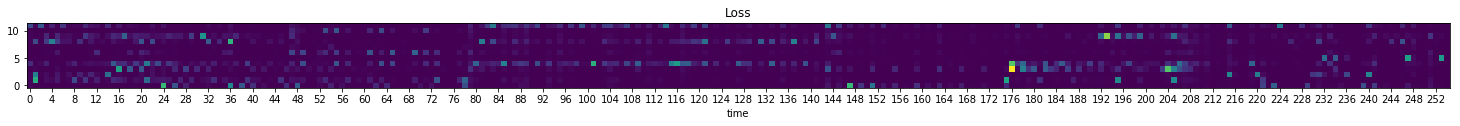

0.163488


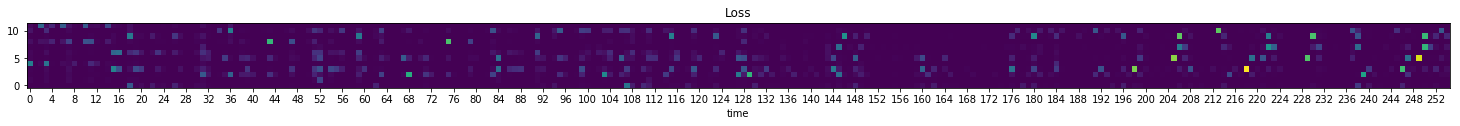

0.160209


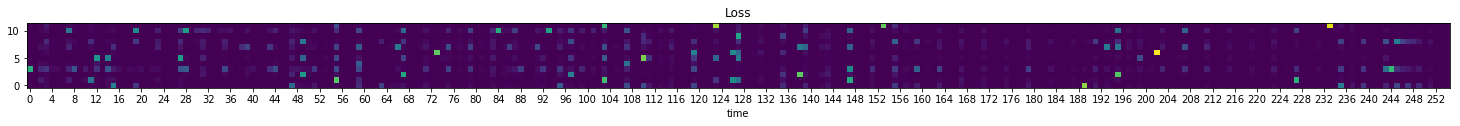

0.153416


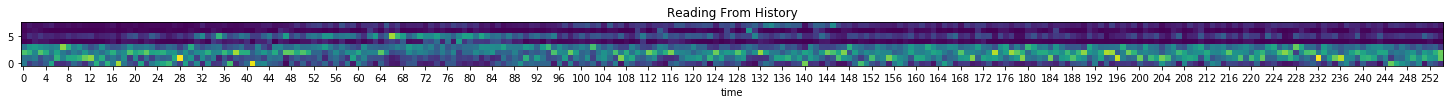

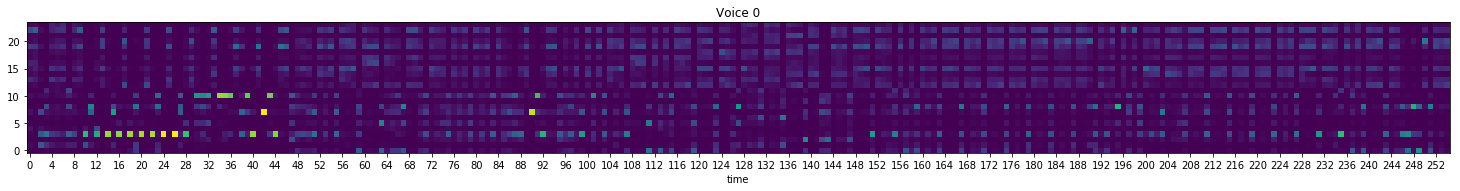

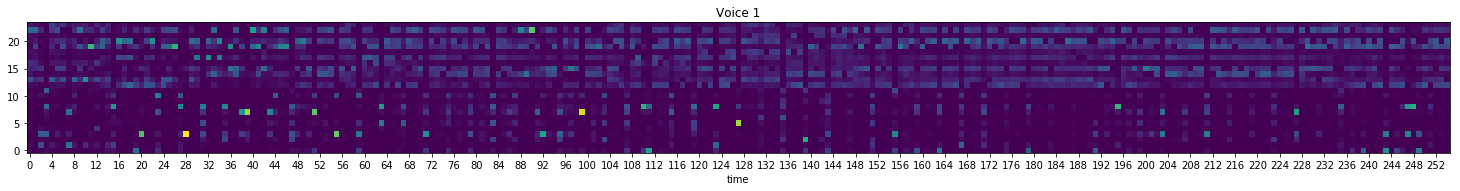

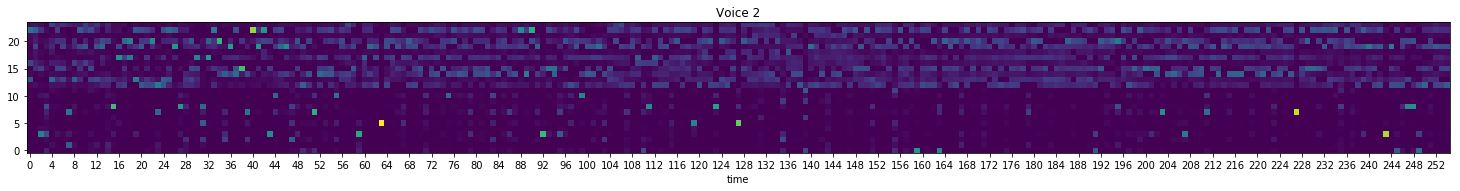

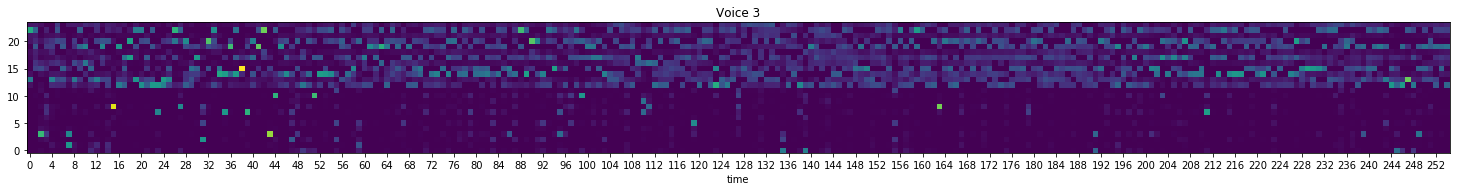

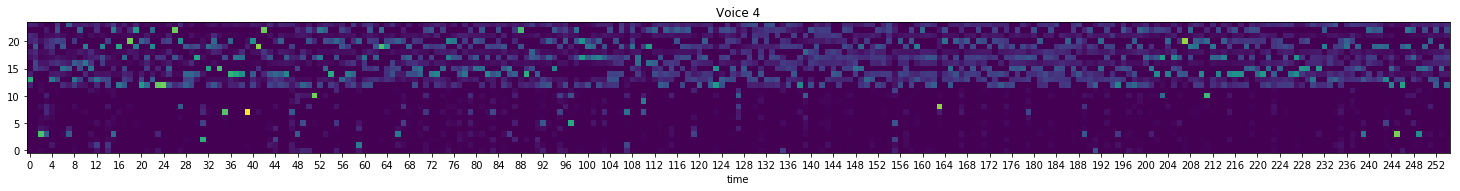

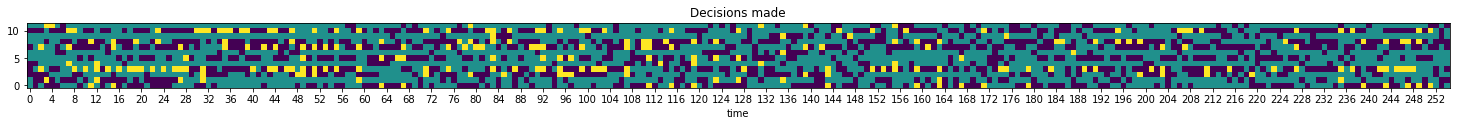

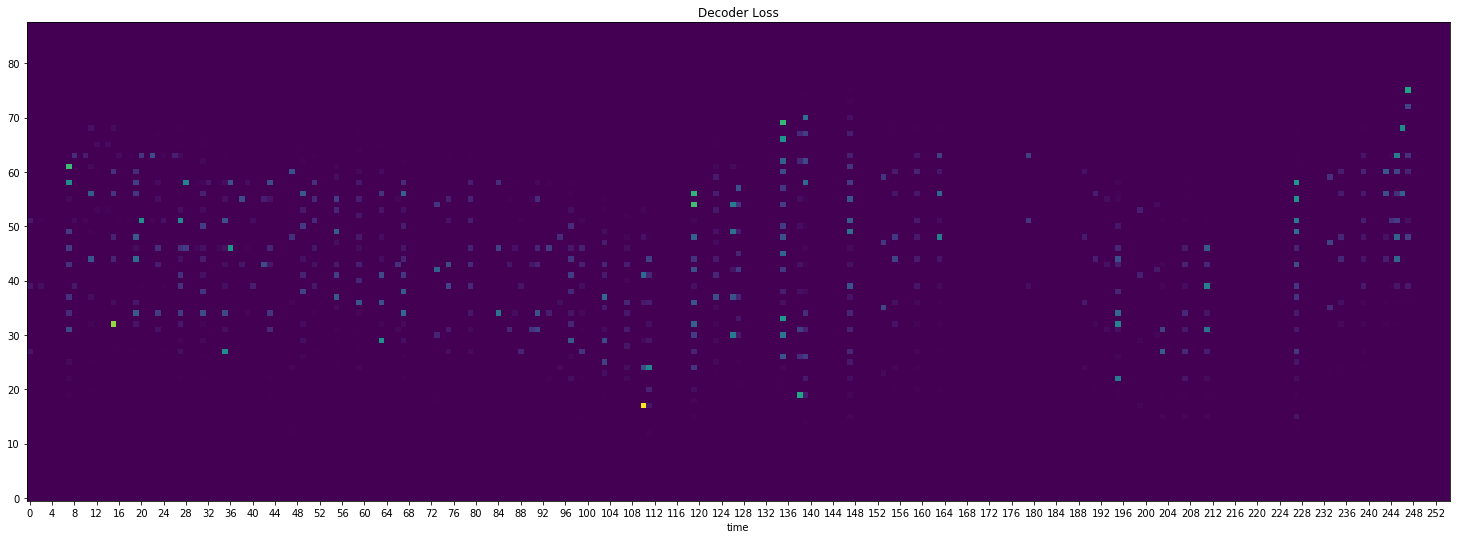

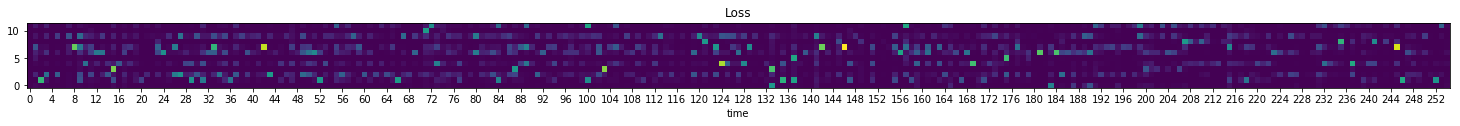

0.156546


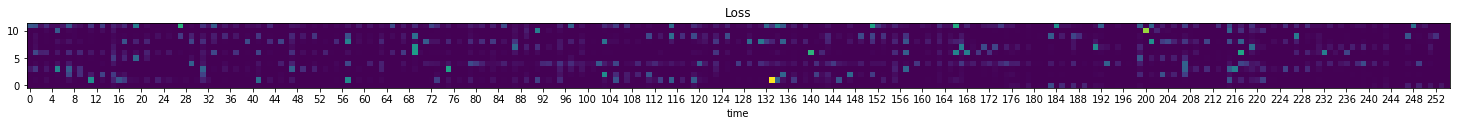

0.159539


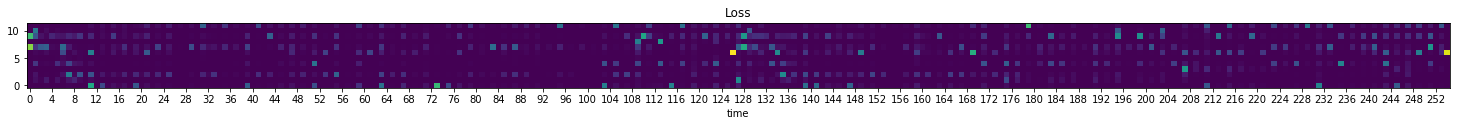

0.164255


In [ ]:
losses = []
decoder_losses = []
optimizer = optim.Adam(model.parameters(), lr=0.01)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.01)

for batch_x, batch_history_init, batch_decoded in batchGenerator():
    
    loss, decoder_loss, read_index, voice_probas, voice_decisions = \
        learn(model, decoder, batch_x, batch_history_init, batch_decoded, optimizer, decoder_optimizer)
           
    if len(losses) % 25 == 0:
        drawNotes(loss[:, 0], "Loss")
        print(loss.mean())
        
        if len(losses) % 100 == 0:
            drawNotes(read_index[:, 0], "Reading From History")
            
            decisions = np.zeros_like(voice_decisions[:, 0, 0, :12])
            for i in range(VOICES):
                drawNotes(voice_probas[:, i, 0], "Voice " + str(i))
                decisions += voice_decisions[:, i, 0, :12]
                decisions -= voice_decisions[:, i, 0, 12:]
            
            drawNotes(decisions, "Decisions made")
            
            drawNotes(decoder_loss[:, 0], "Decoder Loss")
        
    losses.append(loss.mean())
    decoder_losses.append(decoder_loss.mean())

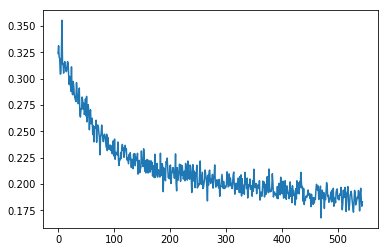

In [105]:
plt.plot(losses)
#plt.ylim([0.14, 0.19])

In [600]:
decoder_loss.mean()

0.018923562

In [619]:
torch.save(model.state_dict(), "my second pytorch model.pt")

## Юзаем

In [107]:
n = np.random.randint(0, len(songs))
cgen, gen = sample(model, decoder, compress(songs[n][:16]).astype(np.float32), songs[n][:16].astype(np.float32), 128)

In [108]:
from songs import *

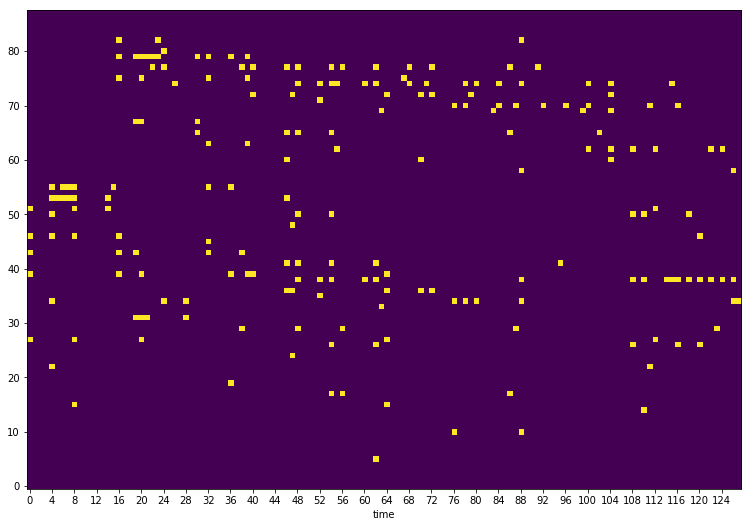

In [109]:
drawNotes(gen)

In [110]:
Song(gen, finished=True).play()

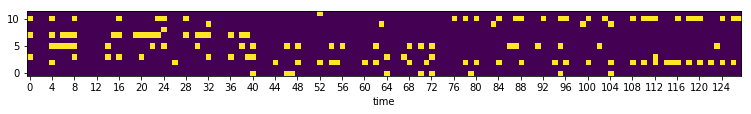

In [111]:
drawNotes(cgen)

In [112]:
full_midi = np.zeros((cgen.shape[0], 88))
full_midi[:, 40:52] = cgen

In [113]:
Song(full_midi, finished=True).play()

In [155]:
# to delete
    
    
    if step % display_step == 0:
        print(L.mean(), " mean for last: ", np.array(losses)[-display_step:].mean())
        drawNotes(L[0], "Loss")
        
        if step % 200 == 0:
            r = sess.run(read_index, feed_dict=fd)
            drawNotes(r[0], "Read")
            
            sn = sess.run(voices_proba, feed_dict=fd)
            for i in range(5):
                drawNotes(sn[i][0], "Voice " + str(i))
            
            sn = sess.run(sampled_notes, feed_dict=fd)
            drawNotes(sn[0] - batch_x[0, 1:, :12]*(1-sn[0]), "Sampled Notes")
                
            sn = sess.run(decoder_ce, feed_dict=fd)
            drawNotes(sn[0], "Decoder Loss")
           
    if len(losses) > display_step and np.array(losses)[-display_step:].mean() < RECORD:
        RECORD = np.array(losses)[-display_step:].mean()
        saver.save(sess, "./tmp/100-100-130 HistoryUser LSTM collapsed Greats1_dataset 8-history 6-times 100-LSTMconditional banning no aposter 100-decoder lr=0.008.ckpt")


IndentationError: unexpected indent (<ipython-input-155-2007eb533ec6>, line 4)